In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np
import scipy
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from timm import create_model
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit


In [2]:
# Load the train and test datasets

DATA_DIR = "/kaggle/input/amia-public-challenge-2024/"
TRAIN_DIR = os.path.join(DATA_DIR, "train/train")
TEST_DIR = os.path.join(DATA_DIR, "test/test")


# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print(f"\n... The number of training files is {len(TRAIN_DICOM_PATHS)} ...")
print(f"... The number of testing files is {len(TEST_DICOM_PATHS)} ...")

# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")
IMG_SIZE_CSV = os.path.join(DATA_DIR, "img_size.csv")

# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
img_size_df = pd.read_csv(IMG_SIZE_CSV)


print("\n\nTRAIN DATAFRAME\n\n")
display(train_df.head(3))


... The number of training files is 8573 ...
... The number of testing files is 6427 ...


TRAIN DATAFRAME




,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,No finding,14,R5,NaN,NaN,NaN,NaN
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R10,1148.0,503.0,1466.0,823.0
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,Consolidation,4,R8,264.0,732.0,550.0,1119.0


In [3]:
train_df['class_name'] = np.where(train_df['class_name'] == 'No finding', 'No Finding', 'Finding')
train_df['class_id'] = np.where(train_df['class_id'] == 14, 0, 1)

In [4]:
batch_size = 64

In [5]:
'''# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=3)
])
'''

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(512),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Grayscale(num_output_channels=3)
])

val_transform = transforms.Compose([
    transforms.Resize(550),  
    transforms.CenterCrop(512),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=3)
])

test_transform = transforms.Compose([
    transforms.Resize(550),  # Resize to a slightly larger size
    transforms.CenterCrop(512),  # Crop to the expected input size for EfficientNet-B4
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=3)
])



# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, split="train"):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0] + '.png'  # Assuming images are stored as png files
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        #convert to color
        # Convert to RGB if the image is grayscale
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.split=="train":
#             if (self.dataframe.iloc[idx, 2]==14):
#                 class_id = 0 # normal
#             else:
#                 class_id = 1 # lesion
            class_id = self.dataframe.iloc[idx, 2]  # Class ID
        elif self.split=="val":
            class_id = self.dataframe.iloc[idx,2]
        else:
            class_id = 0 # we don't know the label for the test.
        if self.transform:
                image = self.transform(image)

        return image, class_id


In [6]:
def stratified_split(dataframe, test_size=0.2):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_idx, val_idx in split.split(dataframe, dataframe['class_id']):
        train_df = dataframe.iloc[train_idx]
        val_df = dataframe.iloc[val_idx]
    return train_df, val_df

In [7]:
train_df , val_df = stratified_split(train_df)

In [8]:
print(f"{train_df.shape},{val_df.shape}")

(36740, 8),(9185, 8)


In [9]:
train_dataset = CustomDataset(dataframe=train_df, root_dir=TRAIN_DIR, split="train", transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(dataframe=val_df, root_dir=TRAIN_DIR,split="val",transform=val_transform)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

test_dataset = CustomDataset(dataframe=test_df, root_dir=TEST_DIR,split="test",transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [10]:
class_counts = train_df.iloc[:, 2].value_counts().sort_index().values
class_counts

array([12420, 24320])

In [15]:
class_weights = len(train_df) / (2*class_counts)
class_weights

array([1.47906602, 0.75534539])

In [18]:
class_weights = torch.Tensor(class_weights)
class_weights

tensor([1.4791, 0.7553])

In [12]:
for i in range(class_counts.shape[0]):
    print("Class count: {}, Total Number of Classes/ (Number of Classes * Class Count) {}".format(class_counts[i],class_weights[i]))

Class count: 12420, Total Number of Classes/ (Number of Classes * Class Count) 1.4790660225442833
Class count: 24320, Total Number of Classes/ (Number of Classes * Class Count) 0.7553453947368421


In [21]:
model = create_model('resnet50', pretrained=False, num_classes=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

if NUM_GPU > 1:
    model = nn.DataParallel(model)

model.load_state_dict(torch.load("/kaggle/input/valsplit-amia-model/pytorch/v1/1/ResNet50_binary_BSIZE64_5EPOCH_VALSPLIT.pth"))

[INFO] number of GPUs found: 2...


<All keys matched successfully>

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.01) # old  LR = 0.001

# Train the model
num_epochs = 5 # then 5-6
print(device)

cuda:0


In [23]:
NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

if NUM_GPU > 1:
    model = nn.DataParallel(model)

[INFO] number of GPUs found: 2...


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.01) # old  LR = 0.001

# Train the model
num_epochs = 5 # then 5-6
print(device)

cuda:0


In [28]:
# INFERENCE

model = create_model('resnet50', pretrained=False, num_classes=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

model.to(device)

if NUM_GPU > 1:
    model = nn.DataParallel(model)

model.load_state_dict(torch.load("/kaggle/input/valsplit-amia-model/pytorch/v1/1/ResNet50_binary_BSIZE64_5EPOCH_VALSPLIT.pth"))


[INFO] number of GPUs found: 2...


<All keys matched successfully>

In [29]:
# Inference on the test dataset
model.to(device)
model.eval()

test_predictions = []
test_probabilities = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(val_dataloader):
        print("doing batch", i)
        # Unpack the data batch
        inputs, labels = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities = F.softmax(outputs, dim=1).max(dim=1)[0]

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        all_labels.extend(labels
                          .cpu().numpy())

doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 22
doing batch 23
doing batch 24
doing batch 25
doing batch 26
doing batch 27
doing batch 28
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42
doing batch 43
doing batch 44
doing batch 45
doing batch 46
doing batch 47
doing batch 48
doing batch 49
doing batch 50
doing batch 51
doing batch 52
doing batch 53
doing batch 54
doing batch 55
doing batch 56
doing batch 57
doing batch 58
doing batch 59
doing batch 60
doing batch 61
doing batch 62
doing batch 63
doing batch 64
doing batch 65
doing batch 66
doing

In [31]:
from sklearn.metrics import precision_recall_fscore_support

val_df['predicted_class'] = test_predictions
val_df['probabilities'] = test_probabilities
print(test_df.head())

# Calculate the F1, Precision, and Recall scores for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, test_predictions, average=None)

for i in range(len(precision)):
    print(f'Class {i}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1 Score: {f1[i]}')

                           image_id
0  3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c
1  LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm
2  PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W
3  l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL
4  if5Pqu95xLUtURzAo72YiSg8GNzJb1F3
Class 0:
Precision: 0.5882654368434538
Recall: 0.7394524959742351
F1 Score: 0.6552511415525115
Class 1:
Precision: 0.8468383188186293
Recall: 0.7356907894736842
F1 Score: 0.7873613800387256


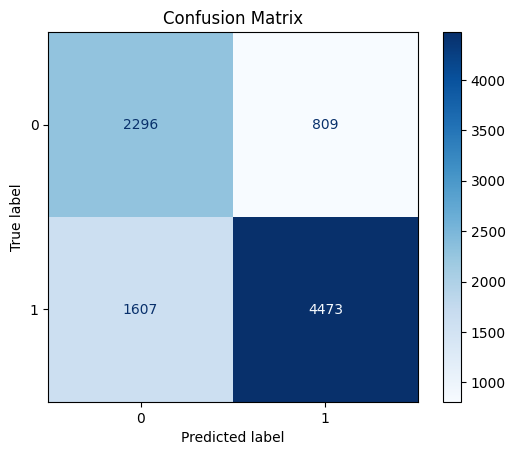

In [32]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming test_predictions, test_probabilities, and all_labels are already populated as per your code

# Compute the confusion matrix
cm = confusion_matrix(all_labels, test_predictions)

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 22
doing batch 23
doing batch 24
doing batch 25
doing batch 26
doing batch 27
doing batch 28
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42
doing batch 43
doing batch 44
doing batch 45
doing batch 46
doing batch 47
doing batch 48
doing batch 49
doing batch 50
doing batch 51
doing batch 52
doing batch 53
doing batch 54
doing batch 55
doing batch 56
doing batch 57
doing batch 58
doing batch 59
doing batch 60
doing batch 61
doing batch 62
doing batch 63
doing batch 64
doing batch 65
doing batch 66
doing

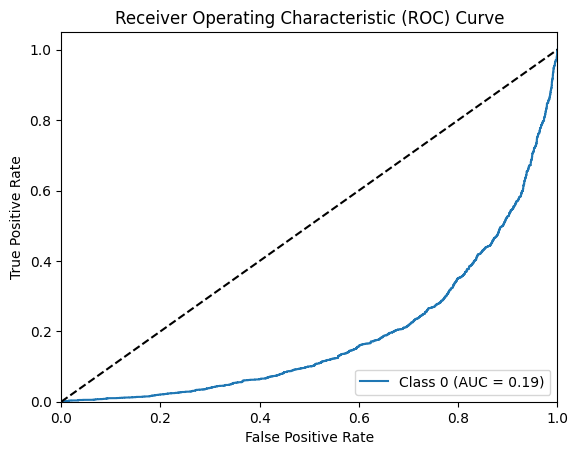

In [37]:
model.eval()

test_predictions = []
test_probabilities = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for i, data in enumerate(val_dataloader):
        print("doing batch", i)
        # Unpack the data batch
        inputs, labels = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities = F.softmax(outputs, dim=1)

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Assuming test_predictions, test_probabilities, and all_labels are already populated as per your code
# If it's a multi-class classification, binarize the labels
all_labels_bin = label_binarize(all_labels, classes=np.arange(len(set(all_labels))))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = all_labels_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probabilities)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [39]:
all_labels_bin_rev = np.where(all_labels_bin == 0, 1, 0)

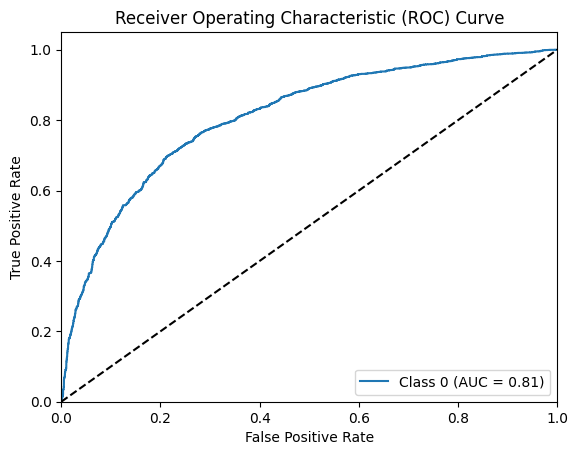

In [42]:
all_labels_bin_rev = np.where(all_labels_bin == 0, 1, 0)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = all_labels_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin_rev[:, i], np.array(all_probabilities)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [43]:
# INFERENCE

model = create_model('resnet50', pretrained=False, num_classes=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

model.to(device)

if NUM_GPU > 1:
    model = nn.DataParallel(model)

model.load_state_dict(torch.load("/kaggle/input/amia-resnet50-bsize64-5epochs/pytorch/v1/1/ResNet50_binary_BSIZE64_5EPOCH.pth"))


[INFO] number of GPUs found: 2...


<All keys matched successfully>

In [44]:
# Inference on the test dataset
model.to(device)
model.eval()

test_predictions = []
test_probabilities = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(val_dataloader):
        print("doing batch", i)
        # Unpack the data batch
        inputs, labels = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities = F.softmax(outputs, dim=1).max(dim=1)[0]

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        all_labels.extend(labels
                          .cpu().numpy())

doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 22
doing batch 23
doing batch 24
doing batch 25
doing batch 26
doing batch 27
doing batch 28
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42
doing batch 43
doing batch 44
doing batch 45
doing batch 46
doing batch 47
doing batch 48
doing batch 49
doing batch 50
doing batch 51
doing batch 52
doing batch 53
doing batch 54
doing batch 55
doing batch 56
doing batch 57
doing batch 58
doing batch 59
doing batch 60
doing batch 61
doing batch 62
doing batch 63
doing batch 64
doing batch 65
doing batch 66
doing

                           image_id
0  3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c
1  LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm
2  PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W
3  l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL
4  if5Pqu95xLUtURzAo72YiSg8GNzJb1F3
Class 0:
Precision: 0.7133266196710305
Recall: 0.6843800322061192
F1 Score: 0.6985535831689678
Class 1:
Precision: 0.8420883016435707
Recall: 0.8595394736842106
F1 Score: 0.8507244017580986


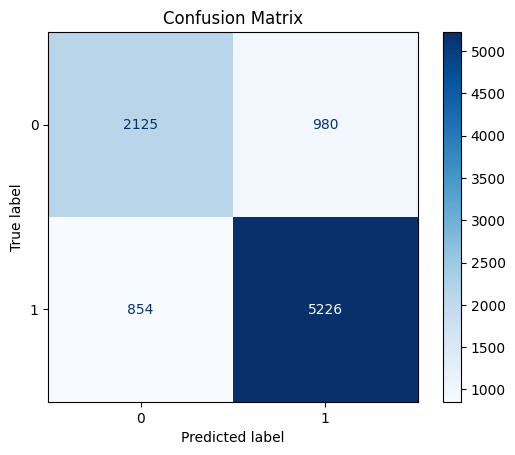

In [45]:
from sklearn.metrics import precision_recall_fscore_support

val_df['predicted_class'] = test_predictions
val_df['probabilities'] = test_probabilities
print(test_df.head())

# Calculate the F1, Precision, and Recall scores for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, test_predictions, average=None)

for i in range(len(precision)):
    print(f'Class {i}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1 Score: {f1[i]}')
    
    
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming test_predictions, test_probabilities, and all_labels are already populated as per your code

# Compute the confusion matrix
cm = confusion_matrix(all_labels, test_predictions)

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 22
doing batch 23
doing batch 24
doing batch 25
doing batch 26
doing batch 27
doing batch 28
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42
doing batch 43
doing batch 44
doing batch 45
doing batch 46
doing batch 47
doing batch 48
doing batch 49
doing batch 50
doing batch 51
doing batch 52
doing batch 53
doing batch 54
doing batch 55
doing batch 56
doing batch 57
doing batch 58
doing batch 59
doing batch 60
doing batch 61
doing batch 62
doing batch 63
doing batch 64
doing batch 65
doing batch 66
doing

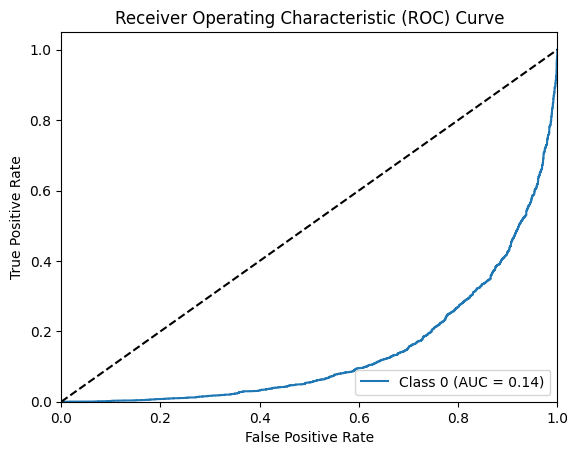

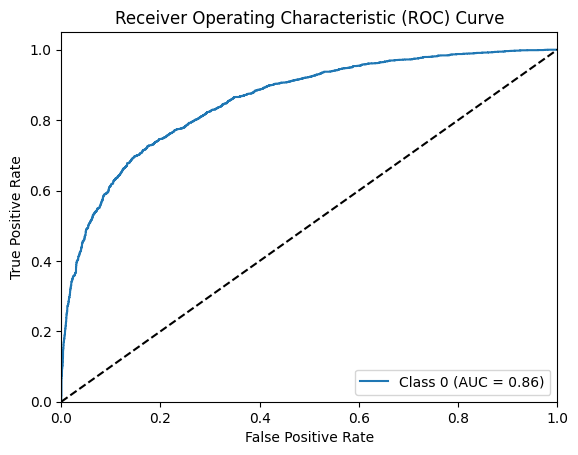

In [46]:
model.eval()

test_predictions = []
test_probabilities = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for i, data in enumerate(val_dataloader):
        print("doing batch", i)
        # Unpack the data batch
        inputs, labels = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities = F.softmax(outputs, dim=1)

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Assuming test_predictions, test_probabilities, and all_labels are already populated as per your code
# If it's a multi-class classification, binarize the labels
all_labels_bin = label_binarize(all_labels, classes=np.arange(len(set(all_labels))))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = all_labels_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probabilities)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


all_labels_bin_rev = np.where(all_labels_bin == 0, 1, 0)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = all_labels_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin_rev[:, i], np.array(all_probabilities)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


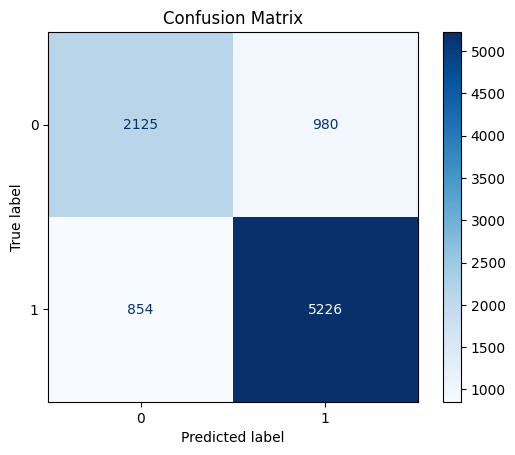

In [47]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, test_predictions)

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

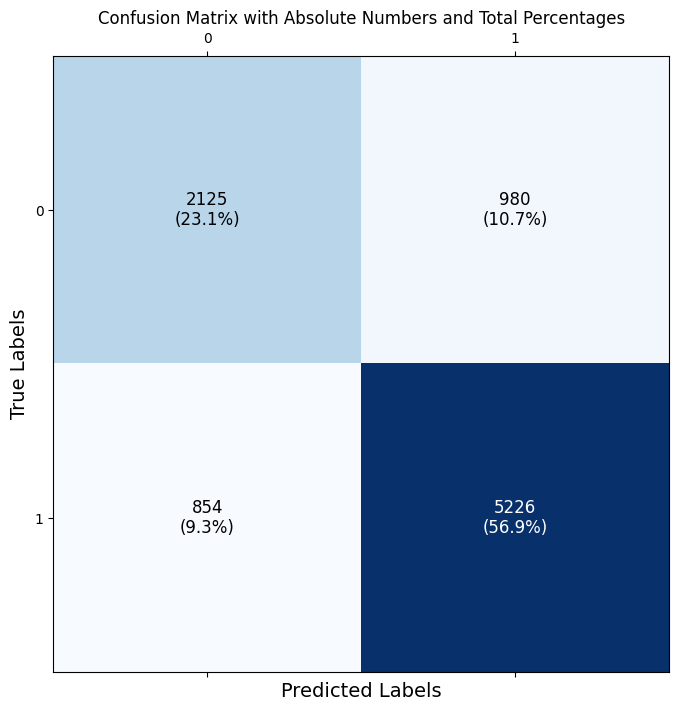

In [54]:
cm = confusion_matrix(all_labels, test_predictions)

# Calcular los porcentajes totales
cm_total = np.sum(cm)
cm_perc = cm / cm_total * 100

# Configurar la gráfica
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Añadir una barra de color
#fig.colorbar(cax)

# Añadir los valores absolutos y los porcentajes totales a cada celda
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}\n({cm_perc[i, j]:.1f}%)',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=12)

# Configurar los ejes
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('True Labels', fontsize=14)
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(np.arange(cm.shape[1]))
ax.set_yticklabels(np.arange(cm.shape[0]))
plt.title('Confusion Matrix with Absolute Numbers and Total Percentages', fontsize=12)

plt.show()

In [ ]:
# GRAD CAM 
    


In [ ]:
# grad cam + bounding boxes above the image

